# Demo of the Whittaker filter
Spectra are often corrupted by uncorrelated random noise. As such, smoothing is frequently a useful option to improve the quality of the spectra for visualization but also for chemometric analysis. Frequently, Savitzky-Golay smoothing is used. It however has some drawback such as:
- two parameters which need to be optimized
- parameters may not be varied continously (integer values required)
- speed
- choosing ideal parameters poses a challenge

Eilers et al. [1] proposed to use a Whittaker smoother instead, which improves on all four points. chemometrics implements the Whittaker smoother with additional gimics such as automatic estimation of the ideal smoothing parameter. The following example shows how the Whittaker smoother may be applied based on artificial data. First, the necessary libraries are imported.

In [1]:
import sys
sys.path.append('../')
import numpy as np
import chemometrics as cm
import matplotlib.pyplot as plt

Here, we want to mimique Raman spectra with a broad background contribution. `generate_spectra` and `generate_background` are helper functions exactly for this application. `generate_spectra` generates a spectra with Gaussian peaks of random intensity and peak width. `generate_background` uses a Gaussian process to generate broad background features. By adding the output of the two functions, an artificial spectrum is obtained.

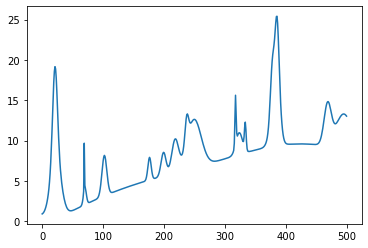

In [2]:
n_wl = 500
n_band = 20
bandwidth = 2.2
n_samples = 50

S = np.abs(cm.generate_background(n_wl)) * 5 + cm.generate_spectra(n_wl, n_band,
                                                       bandwidth)
lines = plt.plot(S.T)

Using some randomly generated concentrations and adding Gaussian noise, a number of spectra are obtained. The spectra can now be plotted with the `plot_colored_series` function. The spectra spectra are colored by concentration for easier distinction.

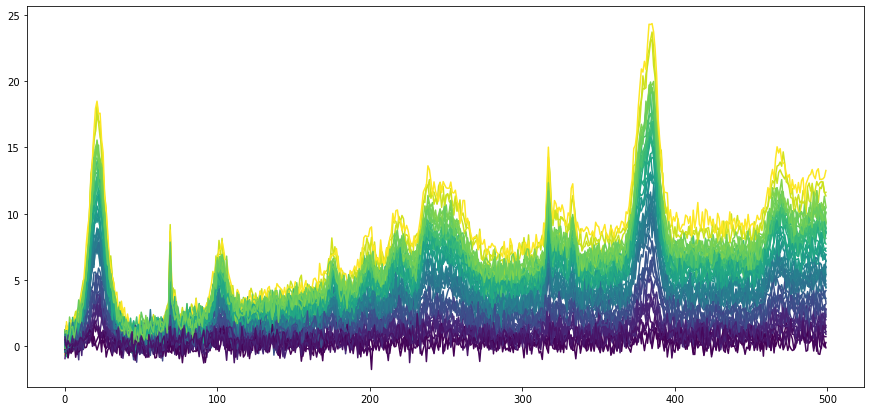

In [3]:
C = np.random.uniform(size=n_samples)
X = C[:,None] * S
X = X + np.random.normal(size=X.shape, scale=0.5)

plt.figure(figsize=(15, 7))
lines = cm.plot_colored_series(X.T, reference=C)

The `Whittaker` class provides a score parameter which is based on a leave-one-out cross-validation. The score provides an estimate for the mean error after smoothing. This can be tested for the artificial spectra. The penalty is iteratively varied over 5 orders of magnitude and after each iteration the score is read out. Finally, the scores are plotted against the penalty.

[]

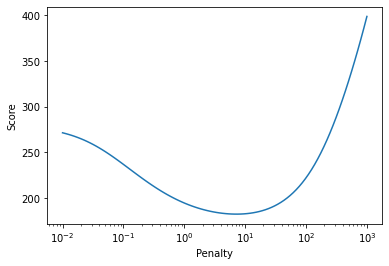

In [4]:
n_points = 100

penalties = 10 ** np.linspace(-2, 3, n_points)
scores = np.zeros(penalties.shape)

whittaker = cm.Whittaker(penalty=1)

for i in range(n_points):
    whittaker.penalty_ = penalties[i]
    whittaker.fit(X)
    scores[i] = whittaker.score(X)
    
plt.plot(penalties, scores,)
plt.xlabel('Penalty')
plt.ylabel('Score')
ax = plt.gca()
ax.semilogx()


The penalty versus score plot shows that there is a local minimum, i.e. an optimal penalty. By not defining a penalty when initializing the Whittaker filter (or setting the penalty to `'auto'`), the `Whittaker` class runs an optimizer to find an optimal penalty. For normal applications and quick testing, this should be a reasonable starting point. This is shown below, `Whittaker` is initialized without penalty. The smoothed spectra are shown below with the original spectrum shown in red with an offset for comparison. Mostly, the smoothing works fine without distorting the shape of the peaks. In case of very sharp bands, the filter may dilute them due to its smoothing characteristics. This is however typical for also other filters such as Savitzky-Golay and due to the attenuation of high frequency components.

Note: due to the random generation of the spectra, it is not guaranteed that very sharp peaks will be generated in given example.

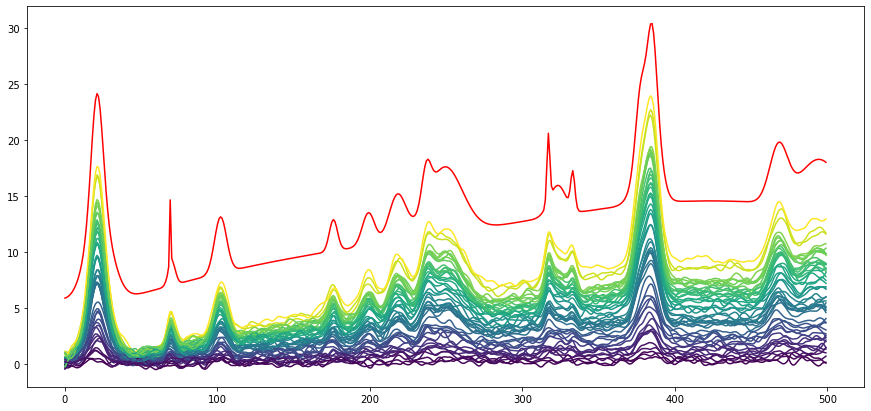

In [5]:
whittaker = cm.Whittaker()
X_smoothed = whittaker.fit_transform(X)
plt.figure(figsize=(15, 7))
lines = cm.plot_colored_series(X_smoothed.T, reference=C)
plt.plot(S.T + 5, 'r')

In [6]:
whittaker.penalty_

7.198159376672956

# Asymmetric Whittaker
Furthermore, chemometrics also implements a Whittaker filter with asymmetric penalty, i.e. weights are applied based the value residuals. If the residuals are smaller zero, they are weighted in the objective function by a factor $\lambda$, otherwise by $1-\lambda$. The asymmetric Whittaker provides the possibility to implement a slowly varying baseline independent of physical assumptions on the baseline. The rigidness of the baseline can be adjusted by the ``penalty`` parameter. The parameter ``asym_factor`` corresponds to $\lambda$. Similar to `Whittaker`, `AsymWhittaker` implements a scikit-learn transformer and may thus easily be used in a pipeline.

The asymmetric Whittaker filter may be applied to the previously introduced artificial dataset to get rid of the baseline effect. This is shown in the first figure below. For reference, the original spectra without any preprocessing are plotted in gray in the background. With the used parameter set, reasonable background spectra are estimated and the baseline offset is largly removed.

The second figure uses the `background` attribute of the asymmetric Whittaker filter to recover the previously fitted backgrounds. One can see that overall, the backgrounds follow a slow trend. The noise impacted the background estimation, which is especially visible towards the edges of the background (less information available).

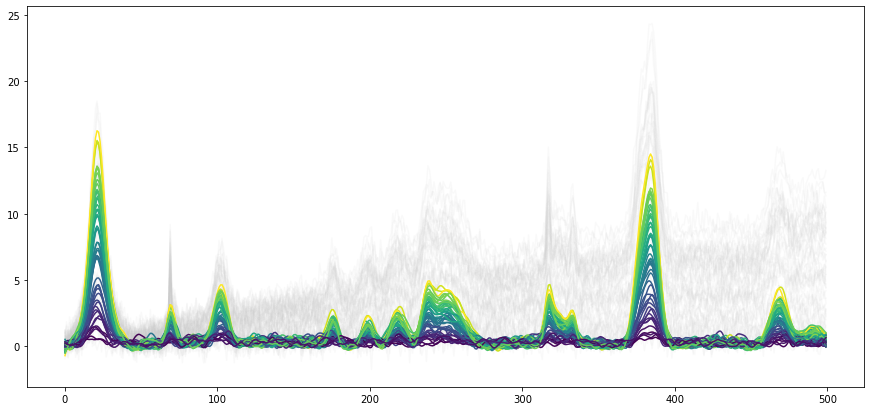

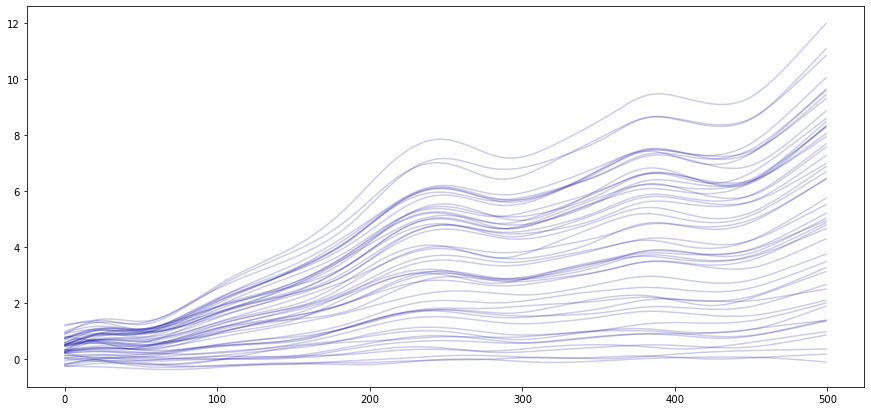

In [14]:
aw = cm.AsymWhittaker(penalty=10000, asym_factor=0.99)
X_bg = aw.fit_transform(X_smoothed)

plt.figure(figsize=(15, 7))
lines = plt.plot(X.T, c=[0.8, 0.8, 0.8], alpha=0.1)
lines = cm.plot_colored_series(X_bg.T, reference=C)

plt.figure(figsize=(15, 7))
lines = plt.plot(aw.background_.T , c=[0, 0, 0.6], alpha=0.2)